## LSTM model for COVID-19 infected count prediction

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mlt 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle

In [2]:
train_df = pd.read_csv('../../../data/main_data/final.csv')
train_df = train_df.sort_values(by=['formal_date','index'])
train_df.head()
print('-------------------------------------------\n', f'training dataset shape : {train_df.shape}')
print('-------------------------------------------\n', 'data distrbution:\n', train_df.nunique())
print('-------------------------------------------\n', 'INFO:', train_df.info())

,index,formal_date,quarter,date,day_of_week,month,Suspected_Local,Suspected_Foreign,temp,humidity,sun_hours,province,neir_infected_cases,locked_percn,TotalInfected
0,1,2020-03-31,1,31,1,3,41,1,28.5,81.0,7.15,1,34,1.0,11
19,2,2020-03-31,1,31,1,3,1,0,28.5,76.0,8.50,1,32,1.0,15
15,3,2020-03-31,1,31,1,3,5,0,29.0,76.0,8.50,1,11,1.0,18
16,4,2020-03-31,1,31,1,3,2,0,28.5,75.0,8.00,2,19,1.0,0
17,5,2020-03-31,1,31,1,3,7,0,28.5,76.0,8.30,2,1,1.0,1


-------------------------------------------
 training dataset shape : (5250, 15)
-------------------------------------------
 data distrbution:
 index                   25
formal_date            210
quarter                  4
date                    31
day_of_week              7
month                    8
Suspected_Local         70
Suspected_Foreign        4
temp                    21
humidity                24
sun_hours              105
province                 9
neir_infected_cases    131
locked_percn            18
TotalInfected           49
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 5249
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                5250 non-null   int64  
 1   formal_date          5250 non-null   object 
 2   quarter              5250 non-null   int64  
 3   date                 5250 non-null   int64  
 4   day_of_week          5250

In [5]:
train_df.columns

Index(['index', 'formal_date', 'quarter', 'date', 'day_of_week', 'month',
       'Suspected_Local', 'Suspected_Foreign', 'temp', 'humidity', 'sun_hours',
       'province', 'neir_infected_cases', 'locked_percn', 'TotalInfected'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(1.0, 0.5, 'Suspected_Local')

<AxesSubplot:>

Text(1.0, 0.5, 'Suspected_Foreign')

<AxesSubplot:>

Text(1.0, 0.5, 'temp')

<AxesSubplot:>

Text(1.0, 0.5, 'humidity')

<AxesSubplot:>

Text(1.0, 0.5, 'sun_hours')

<AxesSubplot:>

Text(1.0, 0.5, 'neir_infected_cases')

<AxesSubplot:>

Text(1.0, 0.5, 'locked_percn')

<AxesSubplot:>

Text(1.0, 0.5, 'TotalInfected')

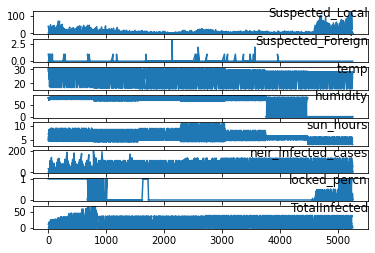

In [6]:
plot_cols = ['Suspected_Local', 'Suspected_Foreign', 'temp','humidity', 'sun_hours', 'neir_infected_cases', 'locked_percn', 'TotalInfected']
plt.figure()
tight_plts = len(plot_cols)
i = 1
for col in plot_cols:
    plt.subplot(tight_plts,1,i)
    plt.plot(train_df.loc[:, col])
    plt.title(col, y=0.5, loc='right')
    i+=1
plt.show()

convert dataset compatible with LSTM model

In [2]:
dataset = pd.read_csv('../../../data/main_data/final_train.csv', header=0, index_col=1)
dataset = dataset.sort_values(by=['formal_date', 'index'])

record_per_dist = dataset.loc[dataset['index'] == 1, :].shape[0]
num_test_days = 10

train = dataset.iloc[:-(num_test_days*25), :]
test = dataset.iloc[-(num_test_days*25):, :]


In [3]:
train.sort_values(by=['index','formal_date'], inplace=True)
test.sort_values(by=['index','formal_date'], inplace=True)

In [4]:
#ensure data in float type
tr_val = train.values
ts_val = test.values

tr_val = tr_val.astype('float32')
ts_val = ts_val.astype('float32')
#values = values.astype('float32')

In [5]:
# normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
tr_scaled = scaler.fit_transform(tr_val)
ts_scaled = scaler.transform(ts_val)

frame dataset to supervised learning

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [7]:
tr_reframed = series_to_supervised(tr_scaled, 1, 1)
ts_reframed = series_to_supervised(ts_scaled, 1, 1)

In [8]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [9]:
tr_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
1,0.0,0.000000,1.000000,0.166667,0.000000,0.398058,0.333333,0.833333,0.899441,0.496732,...,0.485437,0.000000,0.833333,0.921788,0.369935,0.0,0.251256,1.0,0.983716,0.169231
2,0.0,0.333333,0.000000,0.333333,0.142857,0.485437,0.000000,0.833333,0.921788,0.369935,...,0.407767,0.333333,0.833333,0.921788,0.369935,0.0,0.190955,1.0,0.983716,0.169231
3,0.0,0.333333,0.033333,0.500000,0.142857,0.407767,0.333333,0.833333,0.921788,0.369935,...,0.368932,0.000000,0.833333,0.921788,0.369935,0.0,0.055276,1.0,0.983716,0.169231
4,0.0,0.333333,0.066667,0.666667,0.142857,0.368932,0.000000,0.833333,0.921788,0.369935,...,0.436893,0.000000,0.833333,0.921788,0.369935,0.0,0.140704,1.0,0.983716,0.169231
5,0.0,0.333333,0.100000,0.833333,0.142857,0.436893,0.000000,0.833333,0.921788,0.369935,...,0.398058,0.000000,0.833333,0.921788,0.369935,0.0,0.005025,1.0,0.983716,0.169231


train-test splitting

In [10]:
tr_reframed = tr_reframed.values
ts_reframed = ts_reframed.values
train_X, train_y = tr_reframed[:, :-1], tr_reframed[:, -1]
test_X, test_y = ts_reframed[:, :-1], ts_reframed[:, -1]

In [11]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4999, 1, 29) (4999,) (249, 1, 29) (249,)


In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [13]:
model = Sequential()
model.add(LSTM(70, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [14]:
history = model.fit(train_X, train_y, epochs=50, batch_size=25, validation_data=(test_X, test_y))

Epoch 1/50
200/200 [==============================] - 4s 8ms/step - loss: 0.0664 - val_loss: 0.0196
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0129 - val_loss: 0.0110
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 5/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 6/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 8/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 9/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0086
Epoch 10/50
200/200 [==============================] - 1s 4ms/step - loss: 0.0045 - val_loss: 0.0107

In [15]:
# save LSTM model
model.save('../../../data/models/LSTM_1.h5')

#save MinMaxScaler
pickle.dump(scaler, open('../../../data/models/minMax_lsmt_1.pkl', 'wb'))

Evaluation

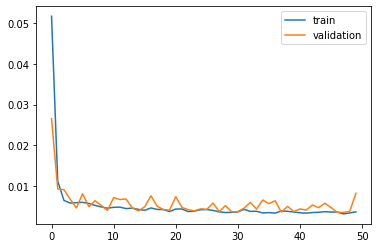

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Predict 

In [17]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [18]:
#inverse scaling for forecasts
inv_yhat = np.concatenate((test_X[:, :13], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [19]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, :13], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.106
